In [ ]:
# models are from ucc-drn-multi-step
# experiment 1: check if the initialized model would still converge under the same circustances
# experiment 2: check if the initialized model would also converge under alpha=1

In [1]:
from hydra import compose, initialize
import omegaconf
import torch
import torch.nn as nn
import torch.nn.functional as F
import mlflow
import optuna
import numpy as np
from tqdm import tqdm
from typing import Tuple
from omegaconf.omegaconf import OmegaConf
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

from model import UCCDRNModel
from dataset import MnistDataset
from utils import get_or_create_experiment, parse_experiment_runs_to_optuna_study
torch.autograd.set_detect_anomaly(True)

d:\UCC-DRN-Pytorch\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# experiment 1
run_name = "ucc-drn-multi-step"
experiment_id = get_or_create_experiment(experiment_name=run_name)
runs = mlflow.search_runs(experiment_ids=[experiment_id], output_format="list")
sucessful_runs = [run for run in runs if float(run.data.metrics["eval_ucc_acc"])>0.5]

In [8]:
run_1 = sucessful_runs[1]
run_id = run_1.info.run_id

In [32]:
model = torch.load(f"mlruns/{experiment_id}/{run_id}/artifacts/best_model.pth/data/model.pth", weights_only=False)
initial_model = torch.load(f"mlruns/{experiment_id}/{run_id}/artifacts/init_model/data/model.pth", weights_only=False)

In [ ]:

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

def init_dataloader(args):
    # assert args.dataset in [
    #     "mnist",
    #     "camelyon",
    # ], "Mode should be either mnist or camelyon"
    # if args.dataset == "mnist":
    train_dataset_len = args.train_num_steps * args.batch_size
    train_dataset = MnistDataset(
        mode="train",
        num_instances=args.num_instances,
        num_samples_per_class=args.num_samples_per_class,
        digit_arr=list(range(args.ucc_end-args.ucc_start+1)),
        ucc_start=args.ucc_start,
        ucc_end=args.ucc_end,
        length=train_dataset_len,
    )
    val_dataset_len = args.val_num_steps * args.batch_size
    val_dataset = MnistDataset(
        mode="val",
        num_instances=args.num_instances,
        num_samples_per_class=args.num_samples_per_class,
        digit_arr=list(range(args.ucc_end-args.ucc_start+1)),
        ucc_start=args.ucc_start,
        ucc_end=args.ucc_end,
        length=val_dataset_len,
    )
    # create dataloader
    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        shuffle=False,
    )
    return train_loader, val_loader


def evaluate(model, val_loader, device, ae_mode, clf_mode) -> dict:
    model.eval()
    val_ae_loss_list = []
    val_ucc_loss_list = []
    val_acc_list = []
    rec_criterion = nn.MSELoss()
    with torch.no_grad():
        for batch_samples, batch_labels in val_loader:
            batch_samples = batch_samples.to(device)
            batch_labels = batch_labels.to(device)
            if ae_mode:
                batch_size, num_instances, num_channel, patch_size, _ = batch_samples.shape
                x = batch_samples.view(-1, num_channel,
                                       batch_samples.shape[-2], batch_samples.shape[-1])
                features = model.encoder(x)
                reconstruction = model.decoder(features)
                reconstruction = reconstruction.view(batch_size, num_instances,
                                    1, patch_size, patch_size)
                ae_loss = rec_criterion(batch_samples, reconstruction)
                val_ae_loss_list.append(ae_loss.item())

            if clf_mode:
                ucc_logits, _ = model(batch_samples)
                ucc_val_loss = F.cross_entropy(ucc_logits, batch_labels)
                # acculate accuracy
                _, ucc_predicts = torch.max(ucc_logits, dim=1)
                acc = torch.sum(
                    ucc_predicts == batch_labels).item() / len(batch_labels)
                val_acc_list.append(acc)
                val_ucc_loss_list.append(ucc_val_loss.item())

        if ae_mode and clf_mode:
            return {
                "eval_ae_loss": np.round(np.mean(val_ae_loss_list), 5),
                "eval_ucc_loss": np.round(np.mean(val_ucc_loss_list), 5),
                "eval_ucc_acc": np.round(np.mean(val_acc_list), 5)
            }
        elif ae_mode:
            return {
                "eval_ae_loss": np.round(np.mean(val_ae_loss_list), 5),
            }
        elif clf_mode:
            return {
                "eval_ucc_loss": np.round(np.mean(val_ucc_loss_list), 5),
                "eval_ucc_acc": np.round(np.mean(val_acc_list), 5)
            }


def train(args, model, optimizer, lr_scheduler, train_loader, val_loader, device):
    # mlflow.pytorch.log_model(model, "init_model")
    # output_dir = hydra.core.hydra_config.HydraConfig.get().runtime.output_dir
    model.train()
    step = 0
    best_eval_acc = 0
    patience = 2
    ae_steps = 500

    rec_criterion = nn.MSELoss()
    if step == 0:
        mlflow.pytorch.log_model(
            model,
            "best_model.pth"
        )
    for batch_samples, batch_labels in tqdm(train_loader):
        batch_samples = batch_samples.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()

        if ae_steps > 0:
            batch_size, num_instances, num_channel, patch_size, _ = batch_samples.shape
            x = batch_samples.view(-1, num_channel,
                                   batch_samples.shape[-2], batch_samples.shape[-1])
            feature = model.encoder(x)

            reconstruction = model.decoder(feature)
            reconstruction = reconstruction.view(
                batch_size, num_instances, 1, patch_size, patch_size)
            loss = rec_criterion(batch_samples, reconstruction)
            ae_loss = loss
            ae_steps -= 1

        if ae_steps == 0:
            ucc_logits, reconstruction = model(batch_samples, batch_labels)
            loss: torch.Tensor = F.cross_entropy(
                ucc_logits,
                batch_labels
            )
            ae_loss = F.mse_loss(batch_samples, reconstruction)

        loss.backward()

        optimizer.step()

        step += 1

        if step % 10 == 0:
            with torch.no_grad():
                metric_dict = {}
                grad_log = {name: torch.mean(param.grad).cpu().item(
                ) for name, param in model.named_parameters() if isinstance(param.grad, torch.Tensor)}
                mlflow.log_metrics(grad_log, step=step)
                metric_dict["train_ae_loss"] = np.round(
                    ae_loss.detach().item(), 5)
                if ae_steps == 0:
                    _, pred = torch.max(ucc_logits, dim=1)
                    accuracy = torch.sum(
                        pred.flatten() == batch_labels.flatten())/len(batch_labels)
                    metric_dict["train_ucc_loss"] = np.round(
                        loss.detach().item(), 5)
                    metric_dict["train_ucc_acc"] = np.round(float(accuracy), 5)

            mlflow.log_metrics(metric_dict, step=step)

        if step % args.save_interval == 0:

            eval_metric_dict = evaluate(
                model,
                val_loader,
                device,
                ae_mode=True,
                clf_mode=(ae_steps == 0))

            print(
                f"step: {step}," + ",".join([f"{key}: {value}"for key, value in eval_metric_dict.items()]))
            mlflow.log_metrics(eval_metric_dict, step=step)
            # early stop
            if ae_steps == 0:
                eval_acc = eval_metric_dict["eval_ucc_acc"]
                if eval_acc > best_eval_acc:
                    patience = 2
                    best_eval_acc = eval_acc
                    mlflow.pytorch.log_model(
                        model,
                        "best_model.pth"
                    )
                else:
                    patience -= 1

            if patience <= 0:
                break
            if step == 10000:
                break
            model.train()

    print("Training finished!!!")
    return best_eval_acc

In [9]:
cfg = OmegaConf.load(f"mlruns/{experiment_id}/{run_id}/artifacts/config.yaml")

In [11]:
print(cfg)

{'args': {'batch_size': 20, 'dataset': 'mnist', 'learning_rate': 0.005, 'model_dir': 'saved_models/', 'model_name': 'mnist_ucc_drn', 'num_bins': 11, 'num_features': 10, 'num_instances': 32, 'num_samples_per_class': 5, 'num_workers': 4, 'save_interval': 1000, 'seed': 22, 'train_num_steps': 100000, 'ucc_end': 4, 'ucc_start': 1, 'val_num_steps': 200}, 'model': {'decoder': {'block1_num_layer': 1, 'block1_output_channel': 64, 'block2_num_layer': 1, 'block2_output_channel': 32, 'block3_num_layer': 1, 'block3_output_channel': 16, 'linear_size': 6272, 'output_channel': 1, 'reshape_size': [7, 7, 128]}, 'drn': {'hidden_q': 100, 'init_method': 'xavier_uniform', 'num_bins': 11, 'num_layers': 2, 'num_nodes': 9, 'output_bins': 4, 'output_nodes': 1}, 'encoder': {'block1_num_layer': 1, 'block1_output_channel': 321, 'block2_num_layer': 1, 'block2_output_channel': 64, 'block3_num_layer': 1, 'block3_output_channel': 128, 'conv_input_channel': 1, 'conv_output_channel': 16, 'flatten_size': 6272, 'num_featu

In [ ]:

mlflow.set_tracking_uri("mlruns")
run_name = "ucc-drn-multi-step-recreation-same-init"
experiment_id = get_or_create_experiment(experiment_name=run_name)
mlflow.set_experiment(experiment_id=experiment_id)
with mlflow.start_run(nested=True):

    defaults = {
        # "init_method": {
        #     "type": "categorical",
        #     "range": ["uniform", "normal", "xavier_uniform", "xavier_normal", "kaiming_uniform", "kaiming_normal"],
        #     "aliases": [
        #         "model.drn.init_method",
        #     ]
        # },
        # "num_bins": {
        #     "type": "int",
        #     "value": 10,
        #     "range": [5, 100],
        #     "aliases": [
        #         "model.drn.num_bins",
        #         "args.num_bins",
        #         "model.kde_model.num_bins"
        #     ]
        # },
        "lr": {
            "type": "float",
            "value": 0.005,
            "range": [0.008, 0.08],
            "aliases": ["args.learning_rate"]
        },
        "hidden_q": {
            "type": "int",
            "value": 100,
            "range": [4, 100],
            "aliases": ["model.drn.hidden_q"]
        },
        "num_layers": {
            "type": "int",
            "value": 2,
            "range": [1, 10],
            "aliases": ["model.drn.num_layers"]
        },
        "num_nodes": {
            "type": "int",
            "value": 9,
            "range": [1, 10],
            "aliases": ["model.drn.num_nodes"]
        }
    }

    print(cfg)
    mlflow.log_dict(dict(OmegaConf.to_object(cfg)), "config.yaml")

    args = cfg.args
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")

    optimizer = torch.optim.Adam(
        model.parameters(), lr=args.learning_rate, amsgrad=True)
    train_loader, val_loader = init_dataloader(args)
    mlflow.pytorch.log_model(model, "init_model")
    best_acc = train(args, model, optimizer, None,
                     train_loader, val_loader, device)

{'args': {'batch_size': 20, 'dataset': 'mnist', 'learning_rate': 0.005, 'model_dir': 'saved_models/', 'model_name': 'mnist_ucc_drn', 'num_bins': 11, 'num_features': 10, 'num_instances': 32, 'num_samples_per_class': 5, 'num_workers': 4, 'save_interval': 1000, 'seed': 22, 'train_num_steps': 100000, 'ucc_end': 4, 'ucc_start': 1, 'val_num_steps': 200}, 'model': {'decoder': {'block1_num_layer': 1, 'block1_output_channel': 64, 'block2_num_layer': 1, 'block2_output_channel': 32, 'block3_num_layer': 1, 'block3_output_channel': 16, 'linear_size': 6272, 'output_channel': 1, 'reshape_size': [7, 7, 128]}, 'drn': {'hidden_q': 100, 'init_method': 'xavier_uniform', 'num_bins': 11, 'num_layers': 2, 'num_nodes': 9, 'output_bins': 4, 'output_nodes': 1}, 'encoder': {'block1_num_layer': 1, 'block1_output_channel': 321, 'block2_num_layer': 1, 'block2_output_channel': 64, 'block3_num_layer': 1, 'block3_output_channel': 128, 'conv_input_channel': 1, 'conv_output_channel': 16, 'flatten_size': 6272, 'num_featu

2025/05/18 20:36:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 20:36:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 20:36:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/18 20:36:29 WARNING mlflow.utils.requirement

training


2025/05/18 20:36:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 20:36:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
  1%|          | 999/100000 [07:58<21:30:47,  1.28it/s]

step: 1000,eval_ae_loss: 1.48017,eval_ucc_loss: 1.22309,eval_ucc_acc: 0.49575


2025/05/18 20:45:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 20:46:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 20:46:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
  2%|▏         | 1999/100000 [18:57<18:02:53,  1.51i

step: 2000,eval_ae_loss: 1.48795,eval_ucc_loss: 1.11717,eval_ucc_acc: 0.6495


2025/05/18 20:56:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 20:56:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
  3%|▎         | 2999/100000 [31:02<14:31:17,  1.86it/s] 2025/05/18 21:08:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requiremen

step: 3000,eval_ae_loss: 1.48912,eval_ucc_loss: 1.03602,eval_ucc_acc: 0.80025


2025/05/18 21:09:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 21:09:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
  4%|▍         | 3999/100000 [44:33<26:19:21,  1.01it/s] 2025/05/18 21:22:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requiremen

step: 4000,eval_ae_loss: 1.48602,eval_ucc_loss: 1.01747,eval_ucc_acc: 0.80325


2025/05/18 21:22:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 21:22:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
  5%|▍         | 4999/100000 [1:00:29<21:51:01,  1.21it/s]2025/05/18 21:38:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requireme

step: 5000,eval_ae_loss: 1.48712,eval_ucc_loss: 0.99745,eval_ucc_acc: 0.813


2025/05/18 21:38:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 21:38:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
  6%|▌         | 6000/100000 [1:12:43<547:27:46, 20.97s/it]

step: 6000,eval_ae_loss: 1.49043,eval_ucc_loss: 0.99573,eval_ucc_acc: 0.80775


  7%|▋         | 6999/100000 [1:22:21<17:08:02,  1.51it/s] 

step: 7000,eval_ae_loss: 1.48624,eval_ucc_loss: 0.98656,eval_ucc_acc: 0.79775


  7%|▋         | 6999/100000 [1:23:33<18:30:12,  1.40it/s]

Training finished!!!


In [37]:
# reinitialize encoder

initial_model = torch.load(f"mlruns/{experiment_id}/{run_id}/artifacts/init_model/data/model.pth", weights_only=False)
new_model = UCCDRNModel(cfg)


encoder_dict = new_model.encoder.state_dict()
# load state dict

(100, 11)
(100, 100)
(4, 100)


In [38]:
initial_model.encoder.load_state_dict(encoder_dict)

<All keys matched successfully>

In [39]:

mlflow.set_tracking_uri("mlruns")
run_name = "ucc-drn-multi-step-recreation-same-init"
experiment_id = get_or_create_experiment(experiment_name=run_name)
mlflow.set_experiment(experiment_id=experiment_id)
with mlflow.start_run(nested=True, run_name="substituted_encoder"):

    defaults = {
        # "init_method": {
        #     "type": "categorical",
        #     "range": ["uniform", "normal", "xavier_uniform", "xavier_normal", "kaiming_uniform", "kaiming_normal"],
        #     "aliases": [
        #         "model.drn.init_method",
        #     ]
        # },
        # "num_bins": {
        #     "type": "int",
        #     "value": 10,
        #     "range": [5, 100],
        #     "aliases": [
        #         "model.drn.num_bins",
        #         "args.num_bins",
        #         "model.kde_model.num_bins"
        #     ]
        # },
        "lr": {
            "type": "float",
            "value": 0.005,
            "range": [0.008, 0.08],
            "aliases": ["args.learning_rate"]
        },
        "hidden_q": {
            "type": "int",
            "value": 100,
            "range": [4, 100],
            "aliases": ["model.drn.hidden_q"]
        },
        "num_layers": {
            "type": "int",
            "value": 2,
            "range": [1, 10],
            "aliases": ["model.drn.num_layers"]
        },
        "num_nodes": {
            "type": "int",
            "value": 9,
            "range": [1, 10],
            "aliases": ["model.drn.num_nodes"]
        }
    }

    print(cfg)
    mlflow.log_dict(dict(OmegaConf.to_object(cfg)), "config.yaml")

    args = cfg.args
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")

    optimizer = torch.optim.Adam(
        initial_model.parameters(), lr=args.learning_rate, amsgrad=True)
    train_loader, val_loader = init_dataloader(args)
    mlflow.pytorch.log_model(initial_model, "init_model")
    best_acc = train(args, model, optimizer, None,
                     train_loader, val_loader, device)

{'args': {'batch_size': 20, 'dataset': 'mnist', 'learning_rate': 0.005, 'model_dir': 'saved_models/', 'model_name': 'mnist_ucc_drn', 'num_bins': 11, 'num_features': 10, 'num_instances': 32, 'num_samples_per_class': 5, 'num_workers': 4, 'save_interval': 1000, 'seed': 22, 'train_num_steps': 100000, 'ucc_end': 4, 'ucc_start': 1, 'val_num_steps': 200}, 'model': {'decoder': {'block1_num_layer': 1, 'block1_output_channel': 64, 'block2_num_layer': 1, 'block2_output_channel': 32, 'block3_num_layer': 1, 'block3_output_channel': 16, 'linear_size': 6272, 'output_channel': 1, 'reshape_size': [7, 7, 128]}, 'drn': {'hidden_q': 100, 'init_method': 'xavier_uniform', 'num_bins': 11, 'num_layers': 2, 'num_nodes': 9, 'output_bins': 4, 'output_nodes': 1}, 'encoder': {'block1_num_layer': 1, 'block1_output_channel': 321, 'block2_num_layer': 1, 'block2_output_channel': 64, 'block3_num_layer': 1, 'block3_output_channel': 128, 'conv_input_channel': 1, 'conv_output_channel': 16, 'flatten_size': 6272, 'num_featu

2025/05/18 23:19:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 23:19:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 23:19:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/18 23:19:22 WARNING mlflow.utils.requirement

training


2025/05/18 23:19:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 23:19:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
  1%|          | 999/100000 [08:26<16:21:34,  1.68it/s]2025/05/18 23:29:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements

step: 1000,eval_ae_loss: 1.29104,eval_ucc_loss: 0.97103,eval_ucc_acc: 0.80625


2025/05/18 23:29:20 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 23:29:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
  2%|▏         | 1999/100000 [18:59<13:39:07,  1.99it/s] 2025/05/18 23:39:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requiremen

step: 2000,eval_ae_loss: 1.28917,eval_ucc_loss: 0.96103,eval_ucc_acc: 0.82175


2025/05/18 23:39:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/18 23:39:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
  3%|▎         | 3000/100000 [30:54<570:15:46, 21.16s/it]

step: 3000,eval_ae_loss: 1.28838,eval_ucc_loss: 0.96541,eval_ucc_acc: 0.8145


  4%|▍         | 3999/100000 [40:09<13:13:45,  2.02it/s] 

step: 4000,eval_ae_loss: 1.29037,eval_ucc_loss: 0.96947,eval_ucc_acc: 0.8105


  4%|▍         | 3999/100000 [41:20<16:32:15,  1.61it/s]

Training finished!!!


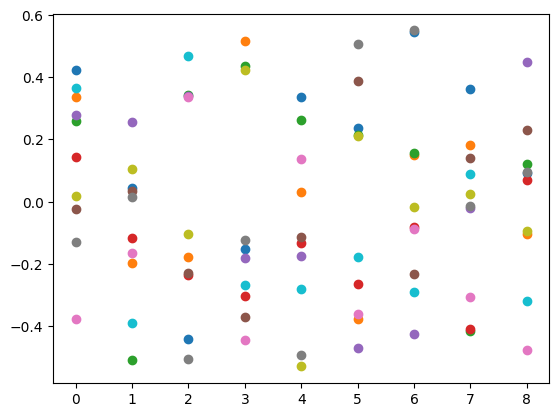

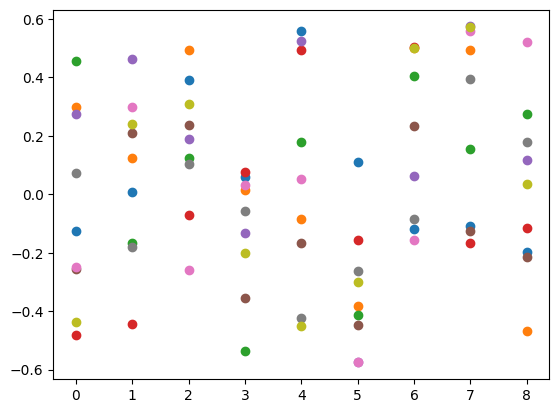

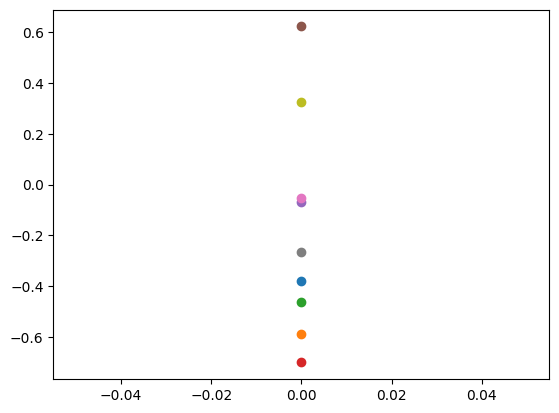

In [ ]:
new_initial_model = torch.load(f"mlruns/{experiment_id}/{sucessful_runs[1].info.run_id}/artifacts/init_model/data/model.pth", weights_only=False)

drn_model = new_initial_model.ucc_classifier
layers = list(drn_model.modules())[1:-1]
import matplotlib.pyplot as plt

with torch.no_grad():
    for layer in layers:
        weights = layer.W.transpose(1,0).cpu().detach().numpy()
        b_a = layer.ba.cpu().detach().numpy()
        b_q = layer.bq.cpu().detach().numpy()
        lama = layer.lama.cpu().detach().numpy()
        lamq = layer.lamq.cpu().detach().numpy()
        for weight in weights:
            plt.scatter(range(len(weight)),weight)
        plt.show()
        plt.scatter

In [60]:
for index, layer in enumerate(layers):
    print(layer.W.shape)
    print(f"b_a_{index}")
    print(layer.ba)
    print(f"b_q_{index}")
    print(layer.bq)
    print(f"lam_a_{index}")
    print(layer.lama)
    print(f"lam_q_{index}")
    print(layer.lamq)
    

torch.Size([9, 10])
b_a_0
Parameter containing:
tensor([[ 0.1863],
        [-0.2506],
        [ 0.0959],
        [-0.1937],
        [ 0.2539],
        [-0.0005],
        [-0.2566],
        [ 0.2855],
        [ 0.2728]], device='cuda:0', requires_grad=True)
b_q_0
Parameter containing:
tensor([[-0.1282],
        [ 0.2378],
        [ 0.1510],
        [-0.0034],
        [-0.0597],
        [-0.2492],
        [-0.2633],
        [-0.1694],
        [ 0.1526]], device='cuda:0', requires_grad=True)
lam_a_0
Parameter containing:
tensor([[0.2792],
        [0.3202],
        [0.4613],
        [0.4577],
        [0.9302],
        [0.1173],
        [0.1408],
        [0.0528],
        [0.1193]], device='cuda:0', requires_grad=True)
lam_q_0
Parameter containing:
tensor([[0.6827],
        [0.7361],
        [0.4714],
        [0.3601],
        [0.4410],
        [0.2559],
        [0.1342],
        [0.7681],
        [0.7807]], device='cuda:0', requires_grad=True)
torch.Size([9, 9])
b_a_1
Parameter containing:

In [68]:
records = []
for run in runs:
    record_dict = {}
    
    new_init_model = torch.load(f"mlruns/{experiment_id}/{run.info.run_id}/artifacts/init_model/data/model.pth", weights_only=False)
    drn = new_init_model.ucc_classifier
    layers = list(drn.modules())[1:-1]
    print(run.data.metrics["eval_ucc_acc"])
    
    for index, layer in enumerate(layers):
        weights = layer.W.detach().cpu().numpy()
        record_dict[f"weights_{index}_std"] = weights.std()
        record_dict[f"weights_{index}_mean"] = weights.mean()
        
        bias_a = layer.ba.detach().cpu().numpy()
        record_dict[f"bias_a_{index}_std"] = bias_a.std()
        record_dict[f"bias_a_{index}_mean"] = bias_a.mean()
        
        bias_q = layer.bq.detach().cpu().numpy()
        record_dict[f"bias_q_{index}_std"] = bias_q.std()
        record_dict[f"bias_q_{index}_mean"] = bias_q.mean()
        
        record_dict[f"lambda_a_{index}_std"] = layer.lama.detach().cpu().numpy().std()
        record_dict[f"lambda_a_{index}_mean"] = layer.lama.detach().cpu().numpy().mean()
        record_dict[f"lambda_q_{index}_std"] = layer.lamq.detach().cpu().numpy().std()
        record_dict[f"lambda_q_{index}_mean"] = layer.lamq.detach().cpu().numpy().mean()
        
    record_dict["acc"] = run.data.metrics["eval_ucc_acc"]
    records.append(record_dict)
        


0.25
0.25
0.25
0.25
0.81225
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.90875
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25


In [72]:
records

[{'weights_0_std': 0.32177463,
  'weights_0_mean': 0.05391548,
  'bias_a_0_std': 0.20895219,
  'bias_a_0_mean': -0.006174455,
  'bias_q_0_std': 0.1309087,
  'bias_q_0_mean': -0.074829236,
  'lambda_a_0_std': 0.340735,
  'lambda_a_0_mean': 0.46042743,
  'lambda_q_0_std': 0.2839391,
  'lambda_q_0_mean': 0.3668749,
  'weights_1_std': 0.2900124,
  'weights_1_mean': 0.023747973,
  'bias_a_1_std': 0.1790416,
  'bias_a_1_mean': 0.014829354,
  'bias_q_1_std': 0.16898686,
  'bias_q_1_mean': 0.07317514,
  'lambda_a_1_std': 0.2220997,
  'lambda_a_1_mean': 0.5977582,
  'lambda_q_1_std': 0.2734221,
  'lambda_q_1_mean': 0.47675562,
  'weights_2_std': 0.49250466,
  'weights_2_mean': -0.22220376,
  'bias_a_2_std': 0.0,
  'bias_a_2_mean': 0.038149804,
  'bias_q_2_std': 0.0,
  'bias_q_2_mean': -0.022425205,
  'lambda_a_2_std': 0.0,
  'lambda_a_2_mean': 0.23235112,
  'lambda_q_2_std': 0.0,
  'lambda_q_2_mean': 0.35825145,
  'acc': 0.25},
 {'weights_0_std': 0.32354942,
  'weights_0_mean': -0.010821161,
  

In [69]:
import pandas as pd

df = pd.DataFrame().from_records(records)

In [73]:
df

,weights_0_std,weights_0_mean,bias_a_0_std,bias_a_0_mean,bias_q_0_std,bias_q_0_mean,lambda_a_0_std,lambda_a_0_mean,lambda_q_0_std,lambda_q_0_mean,...,weights_2_mean,bias_a_2_std,bias_a_2_mean,bias_q_2_std,bias_q_2_mean,lambda_a_2_std,lambda_a_2_mean,lambda_q_2_std,lambda_q_2_mean,acc
0,0.321775,0.053915,0.208952,-0.006174,0.130909,-0.074829,0.340735,0.460427,0.283939,0.366875,...,-0.222204,0.0,0.038150,0.0,-0.022425,0.0,0.232351,0.0,0.358251,0.25000
1,0.323549,-0.010821,0.199974,-0.097995,0.165291,-0.004043,0.222999,0.610874,0.264230,0.492383,...,0.016238,0.0,0.094136,0.0,-0.141515,0.0,0.574813,0.0,0.657295,0.25000
2,0.292646,0.069323,0.217101,0.021971,0.170423,-0.105025,0.286267,0.452614,0.270215,0.551681,...,-0.061890,0.0,0.060599,0.0,0.309784,0.0,0.740813,0.0,0.500773,0.25000
3,0.327465,0.007501,0.196278,-0.083977,0.202035,0.054849,0.194806,0.380651,0.241778,0.340173,...,-0.110938,0.0,-0.037957,0.0,0.133882,0.0,0.513407,0.0,0.099888,0.25000
4,0.299424,-0.047712,0.166465,0.023635,0.095912,-0.013654,0.322138,0.544106,0.262637,0.536966,...,-0.265090,0.0,-0.081086,0.0,-0.043185,0.0,0.216892,0.0,0.189022,0.81225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.302979,0.007843,0.155313,-0.002837,0.155146,-0.100357,0.275752,0.518894,0.206560,0.443364,...,-0.198578,0.0,-0.245526,0.0,0.174687,0.0,0.845389,0.0,0.639310,0.25000
72,0.331758,-0.001758,0.152010,-0.020696,0.181711,-0.000188,0.324019,0.504679,0.210459,0.443955,...,0.274286,0.0,-0.003958,0.0,0.160863,0.0,0.263980,0.0,0.983576,0.25000
73,0.312981,-0.041757,0.165817,0.012536,0.156450,-0.046232,0.301968,0.439671,0.264433,0.653032,...,0.094428,0.0,-0.238728,0.0,0.137173,0.0,0.517863,0.0,0.989394,0.25000
74,0.313229,0.033800,0.148777,0.026570,0.163490,-0.033912,0.305774,0.430965,0.289845,0.582678,...,0.065134,0.0,-0.261276,0.0,0.256001,0.0,0.318776,0.0,0.258273,0.25000


In [ ]:
# bayesian plot should be better

,weights_0_std,weights_0_mean,bias_a_0_std,bias_a_0_mean,bias_q_0_std,bias_q_0_mean,lambda_a_0_std,lambda_a_0_mean,lambda_q_0_std,lambda_q_0_mean,...,weights_2_mean,bias_a_2_std,bias_a_2_mean,bias_q_2_std,bias_q_2_mean,lambda_a_2_std,lambda_a_2_mean,lambda_q_2_std,lambda_q_2_mean,acc
weights_0_std,1.000000,-0.047570,-0.047979,-0.173574,-0.022374,0.111147,-0.012980,0.138581,-0.129002,0.028137,...,0.181063,NaN,0.056790,NaN,-0.054415,NaN,-0.025208,NaN,-0.004155,-0.239098
weights_0_mean,-0.047570,1.000000,0.031378,0.053660,-0.055080,-0.093372,-0.061621,-0.208204,0.208271,-0.104822,...,0.050459,NaN,0.089286,NaN,-0.016890,NaN,-0.119772,NaN,-0.102091,-0.156055
bias_a_0_std,-0.047979,0.031378,1.000000,-0.099953,0.044055,-0.219797,-0.044460,0.048941,0.006197,-0.081942,...,0.087302,NaN,0.215610,NaN,0.235449,NaN,-0.017394,NaN,0.267248,0.100794
bias_a_0_mean,-0.173574,0.053660,-0.099953,1.000000,-0.074233,-0.067187,-0.019445,0.197675,0.062822,0.077027,...,-0.103480,NaN,0.026001,NaN,0.089935,NaN,0.046057,NaN,0.020092,0.099233
bias_q_0_std,-0.022374,-0.055080,0.044055,-0.074233,1.000000,-0.088236,-0.049883,-0.284018,-0.152684,0.010482,...,-0.000025,NaN,0.225573,NaN,-0.025461,NaN,0.092946,NaN,0.137200,-0.201416
bias_q_0_mean,0.111147,-0.093372,-0.219797,-0.067187,-0.088236,1.000000,-0.291588,-0.004694,-0.156005,0.137075,...,0.016356,NaN,0.055988,NaN,-0.125217,NaN,-0.044334,NaN,-0.045811,-0.059538
lambda_a_0_std,-0.012980,-0.061621,-0.044460,-0.019445,-0.049883,-0.291588,1.000000,-0.232704,-0.075614,-0.019988,...,-0.085326,NaN,-0.022818,NaN,0.205679,NaN,-0.006960,NaN,0.083157,0.058536
lambda_a_0_mean,0.138581,-0.208204,0.048941,0.197675,-0.284018,-0.004694,-0.232704,1.000000,-0.061615,0.174070,...,-0.025535,NaN,0.093718,NaN,0.089134,NaN,0.147497,NaN,-0.049270,-0.114971
lambda_q_0_std,-0.129002,0.208271,0.006197,0.062822,-0.152684,-0.156005,-0.075614,-0.061615,1.000000,-0.189590,...,-0.029704,NaN,-0.066946,NaN,0.092247,NaN,-0.000550,NaN,-0.025157,-0.069697
lambda_q_0_mean,0.028137,-0.104822,-0.081942,0.077027,0.010482,0.137075,-0.019988,0.174070,-0.189590,1.000000,...,0.153547,NaN,-0.144672,NaN,0.054873,NaN,0.119715,NaN,0.118793,0.036986
